# Random Forest: Multi-Source ENVO Prediction

**Goal**: Predict ENVO environmental triad terms from satellite imagery across GOLD and NMDC.

**Key Questions**:
1. How well can we predict each ENVO scale (broad/local/medium)?
2. Do different sources show different patterns?
3. What's the impact of removing exact duplicates?

## Setup

In [1]:
from pathlib import Path
import sys

In [2]:
# Add src to path
sys.path.insert(0, str(Path('../src').absolute()))

In [3]:
from env_embeddings.rf_analysis import (
    load_source_data,
    analyze_source,
    create_comparison_table,
    print_summary,
)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## Load Data Sources

In [6]:
# Define data sources (GOLD and NMDC first, NCBI later)
SOURCES = {
    'GOLD': Path('../data/gold_flattened_biosamples_for_env_embeddings_202510061108_complete.csv'),
    'NMDC': Path('../data/nmdc_flattened_biosample_for_env_embeddings_202510061052_complete.csv'),
}

In [ ]:
# Load deduplicated data
datasets_dedup = {}
for source_name, file_path in SOURCES.items():
    df = load_source_data(file_path, source_name, deduplicate=True)
    if df is not None:
        datasets_dedup[source_name] = df

## Train Random Forest Models

## Load Non-Deduplicated Data

In [8]:
# Train models for all sources
all_results = {}
for source_name, df in datasets.items():
    all_results[source_name] = analyze_source(df, source_name)


------------------------------------------------------------
Training models: GOLD
------------------------------------------------------------

  env_broad_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  38 | Test acc: 0.811 | CV: 0.838±0.018 | Overfit: +0.098

  env_local_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes: 130 | Test acc: 0.717 | CV: 0.742±0.016 | Overfit: +0.180

  env_medium...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  72 | Test acc: 0.715 | CV: 0.730±0.020 | Overfit: +0.150

------------------------------------------------------------
Training models: NMDC
------------------------------------------------------------

  env_broad_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  18 | Test acc: 0.919 | CV: 0.928±0.009 | Overfit: +0.033

  env_local_scale...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  50 | Test acc: 0.834 | CV: 0.844±0.015 | Overfit: +0.100

  env_medium...


/Users/MAM/Documents/gitrepos/env-embeddings/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


    Classes:  28 | Test acc: 0.826 | CV: 0.857±0.011 | Overfit: +0.088


## Results Summary

In [9]:
# Create comparison table
comparison_df = create_comparison_table(all_results)

In [10]:
print("\nDetailed Results:")
print(comparison_df.to_string(index=False))


Detailed Results:
Source       Scale  Classes  Samples  Test_Acc  CV_Mean   CV_Std  Overfitting
  GOLD broad_scale       38     4198  0.810714 0.838295 0.009185     0.097564
  GOLD local_scale      130     4198  0.716667 0.741515 0.008047     0.179700
  GOLD      medium       72     4198  0.715476 0.729603 0.010116     0.149920
  NMDC broad_scale       18     4646  0.919355 0.927881 0.004532     0.032744
  NMDC local_scale       50     4646  0.834409 0.844187 0.007307     0.099660
  NMDC      medium       28     4646  0.825806 0.856568 0.005493     0.088079


In [11]:
# Print actionable summary
print_summary(comparison_df)



SUMMARY: Random Forest ENVO Prediction Performance

Overall mean test accuracy: 0.804

Best:  NMDC   broad_scale  = 0.919
Worst: GOLD   medium       = 0.715

Performance by source:
  GOLD  : 0.748 avg, +0.142 overfit
  NMDC  : 0.860 avg, +0.073 overfit

Performance by scale:
  broad_scale : 0.865 avg, 28 avg classes
  local_scale : 0.776 avg, 90 avg classes
  medium      : 0.771 avg, 50 avg classes

ACTIONABLE INSIGHTS

✓ Satellite embeddings have STRONG predictive power for ENVO terms
⚠️  High overfitting detected (max=0.180) - consider regularization


## Visualization: Test Accuracy by Scale

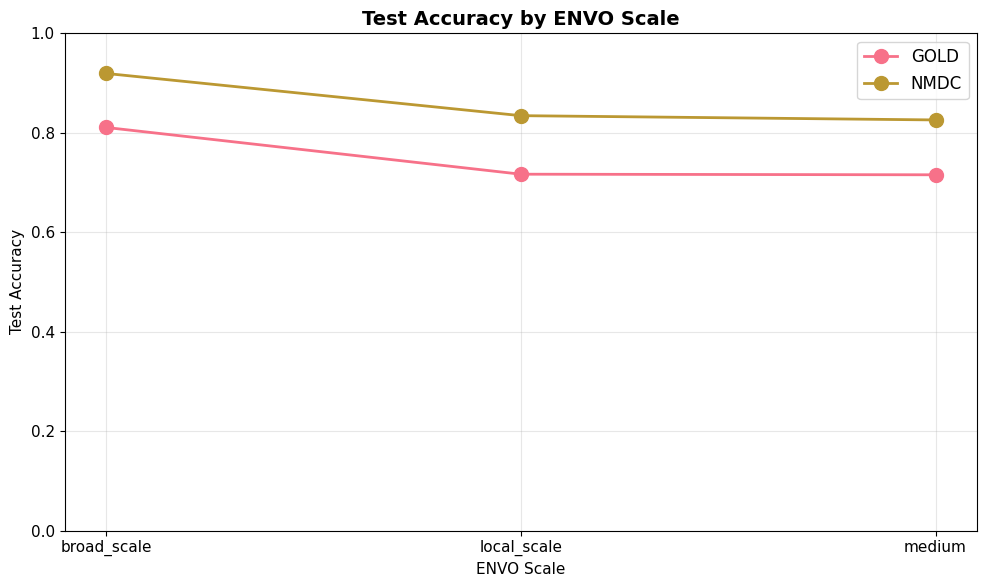

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

for source in comparison_df['Source'].unique():
    data = comparison_df[comparison_df['Source'] == source]
    ax.plot(data['Scale'], data['Test_Acc'],
            marker='o', linewidth=2, markersize=10, label=source)

ax.set_title('Test Accuracy by ENVO Scale', fontsize=14, fontweight='bold')
ax.set_xlabel('ENVO Scale')
ax.set_ylabel('Test Accuracy')
ax.set_ylim(0, 1.0)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization: Average Accuracy by Source

In [13]:
avg_by_source = comparison_df.groupby('Source')['Test_Acc'].mean()

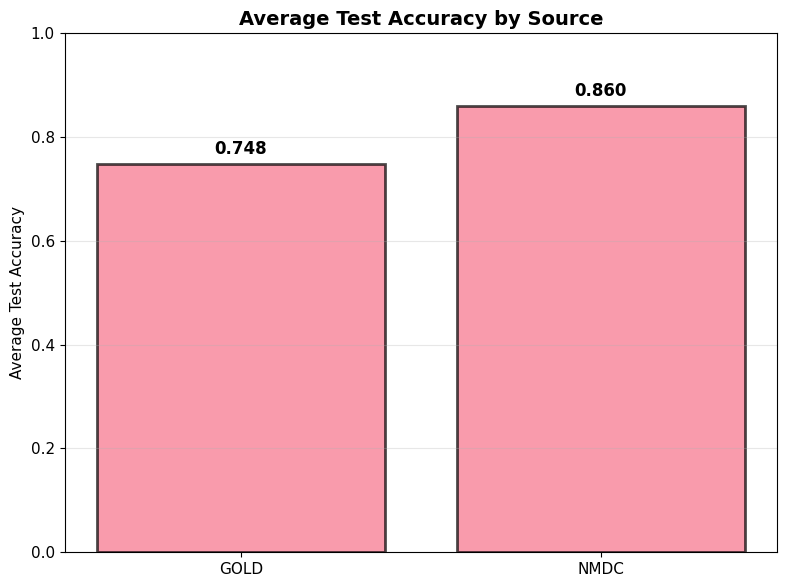

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(avg_by_source.index, avg_by_source.values,
              alpha=0.7, edgecolor='black', linewidth=2)
ax.set_title('Average Test Accuracy by Source', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Test Accuracy')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

## Visualization: Overfitting Check

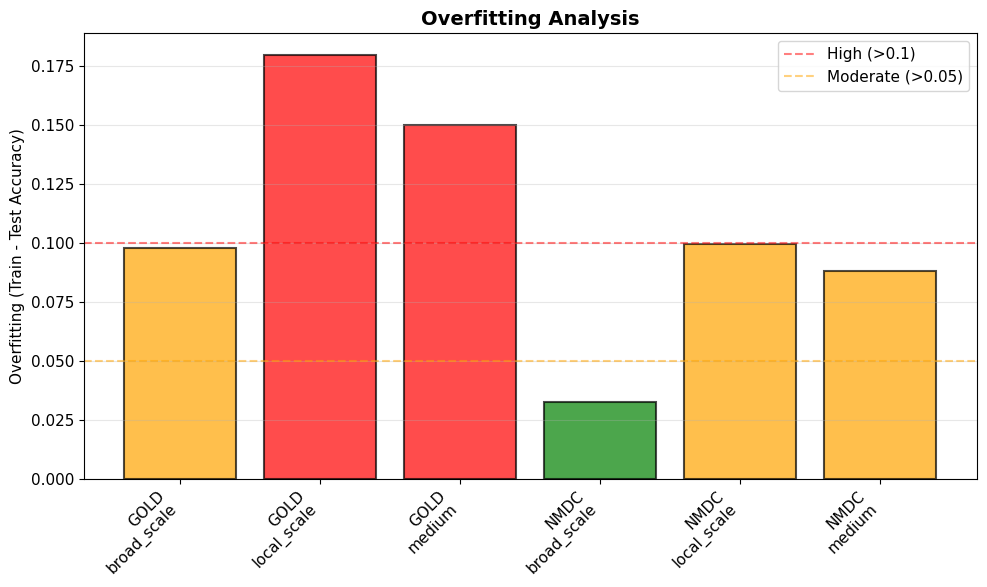

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

# Color bars by overfitting severity
colors = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'green'
          for x in comparison_df['Overfitting'].values]

x_labels = [f"{row['Source']}\n{row['Scale']}"
            for _, row in comparison_df.iterrows()]

bars = ax.bar(range(len(comparison_df)), comparison_df['Overfitting'].values,
              color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(comparison_df)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_ylabel('Overfitting (Train - Test Accuracy)')
ax.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='High (>0.1)')
ax.axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='Moderate (>0.05)')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [16]:
output_dir = Path('../results/rf_multi_source')
output_dir.mkdir(parents=True, exist_ok=True)

In [17]:
output_file = output_dir / 'comparison_results.csv'
comparison_df.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")

Results saved to: ../results/rf_multi_source/comparison_results.csv
